# classification

The purpose of this notebook is to assess different classification techniques with the credit card fraud data.

### import dependancies

In [1]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split
import seaborn as sns
from time import perf_counter
import xgboost as xgb

### read in data

In [2]:
cc = pd.read_parquet('../data/creditcard2.parquet')

display(cc)

,class,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v23,v24,v25,v26,v27,v28,minute,hour,scaled_amount,scaled_seconds
0,False,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0,1.783274,-1.996583
1,False,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,0,-0.269825,-1.996583
2,False,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,0,4.983721,-1.996562
3,False,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0,1.418291,-1.996562
4,False,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0,0.670579,-1.996541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,False,-11.881118,10.071785,-9.834784,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,59,23,-0.296653,1.641931
284803,False,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,59,23,0.038986,1.641952
284804,False,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,59,23,0.641095,1.641974
284805,False,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,59,23,-0.167680,1.641974


## evaluation metrics

The most important peice of information when deciding on evaluation criteria is going to be the massive class imablance. As stated in the Kaggle description of the dataset itself, the best single metric for evaluating a classifier analyzing a highly imbalanced data set will be the Area Under the Precision-Recall Curve. ROC-AUC, R<sup>2</sup>, F1 score, and most other standard metrics for model evaluation will be less useful here; because if our model was to just spit at a negative class for every element it would still have very high levels of performance by all of these metrics. 

What we really need to emphasize is the Recall (also known as True Positive Rate) of the model. Our goal will be to maximize the true postivie results and minimize the false negative. For the sake of making it quantifiable, lets just say that a false neatgive will cost 4 times as much as a false positive. For these reasons, we will focus on the PR-AUC because it focus on the postive class performane, penalizes false positives and negatives more appropriately, and is less biased towards the majority class. We will still collect and observe and other model metrics, but they will be given very little weight in our overall selection of an ideal model. 

The other major metric I beleive is significant here is the exeuction time of the model. Transactional data sets like these can often be millions of rows and if one model offers a massive increase in compute efficiency, even if it comes at a small loss to model perfromance, than it may be the most practical overall pick for real world applications. I'm not going to quantify it here, but let's see what we end up with when we make our final consideration and recommendations.

To summarise, model performanc will be determine by:
1. PR-AUC, Recall
2. Execution Time
3. ROC-AUC, R<sup>2</sup>, F1 Score, Precision

In [3]:
# create empty data frame to store model results
model_performance_results = pd.DataFrame(columns=['pr_auc', 'recall', 'execution_time', 'roc_auc', 'R_squared', 'f1', 'precision'])

# initialize model index counter

## over-sampling and under-sampling

Now that we have our features selected and refined at an indivual field level, let's look at techinques to deal with the massive class imblance of the data. For this analysis I am going to test 2 different techniques to try and mitigate this issue:

### over-sampling with SMOTE

We are going to sue the python imbalanced-learn library to perform an over-sampling over the dataset. We will be using the Synthetic Minority Over-sampling Technique (SMOTE) to generate more samples of the positive class to use for model training.

### random under-samping

For our under-sampling method, we are going to equalize the number of positive and negative class elements in our models. To do this we will train our models with all of the positive class data and randomly select and equal number of negative class elements. This will mean throwing out >99% of the data. Normally, that is not something you would want to do. So why do we want to try it? Because it might maxmize the performance metrics we actually care about. If the under-sampling ends up having a massively negative impact on our true negative rate, this will become readily apparent in our analysis and we may end up disqualifying this techinque from our final model selection.

I am going to go ahead and create all of our training and test sets here, both to improve consistentcy between models, and because you should never write code twice that can be written once.

In [4]:
# break off target from features
X = cc.drop('class', axis=1).values  # Features
y = cc['class'].values  # Target

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# apply SMOTE to over sample
smote = SMOTE(random_state=42)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

# apply undersamping to balance the data
rus = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)

### define functions

#### run model

Function to run the invidivual models. All objects, and the models functions will be passed to this function.

In [5]:
def train_test_model(
    model_name,
    X_train,
    y_train,
    X_test,
    model_function,
    model_parameters={}
):  
    # save the model name into the results data frame
    model_index = 0
    
    start_time = perf_counter()

    model = model_function(**model_parameters)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    end_time = perf_counter()

    # calculate the exectution time and save to the results data frame
    execution_time = end_time - start_time

    # save results to results data frame
    model_performance_results.loc[model_index, 'model_name'] = model_name
    model_performance_results.loc[model_index, 'execution_time'] = execution_time

    # create output object
    model_output = {
        'model_name': model_name,
        'model': model,
        'model_index': model_index,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'execution_time': execution_time,
    }

    return model_output


#### calculate performance metrics

I am going to add a function here to do all of my plotting and performanc metric calcuations, because repeatable code can be used to do it for each of the models I am using below.

In [6]:
def calculate_metrics(
    model_output,
    y_test
):
    y_pred = model_output['y_pred']
    y_pred_proba = model_output['y_pred_proba']

    pass
    # get the pr-auc score
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)

    # get model recall
    recall = recall_score(y_test, y_pred)
    
    # get roc auc score
    roc_auc = roc_auc_score(y_test, y_pred)

    # get f1 statistic
    f1 = f1_score(y_test, y_pred)

    # get r-squared
    R_squared = accuracy_score(y_test, y_pred)

    # get model precision
    precision = precision_score(y_test, y_pred)

    # create a 1 row dataframe to store the results
    model_name = model_output['model_name']
    model_performance_results = pd.DataFrame(columns=['pr_auc', 'recall', 'roc_auc', 'R_squared', 'f1', 'precision'])
    model_performance_results.loc[model_name, 'pr_auc'] = pr_auc
    model_performance_results.loc[model_name, 'recall'] = recall
    model_performance_results.loc[model_name, 'execution_time'] = model_output['execution_time']
    model_performance_results.loc[model_name, 'roc_auc'] = roc_auc
    model_performance_results.loc[model_name, 'R_squared'] = R_squared
    model_performance_results.loc[model_name, 'f1'] = f1
    model_performance_results.loc[model_name, 'precision'] = precision

    return model_performance_results

### visualize perfromance results

In [22]:
def visualize_performance(
    model_output, 
    y_test
):  
    # get recal and precision for prc plot
    y_pred = model_output['y_pred']
    y_pred_proba = model_output['y_pred_proba']
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

    # Create a figure with two subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Plot Precision-Recall curve
    axes[0].plot(recall, precision, marker='.')
    axes[0].set_xlabel('Recall')
    axes[0].set_ylabel('Precision')
    axes[0].set_title('Precision-Recall Curve')

    # Visualize the confusion matrix
    confusion_mat = confusion_matrix(y_test, y_pred)
    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'], ax=axes[1])
    axes[1].set_xlabel('Predicted Label')
    axes[1].set_ylabel('Actual Label')
    axes[1].set_title('Confusion Matrix')

    # Adjust layout and add margin between plots
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.4)  # Adjust the wspace parameter to add margin

    plt.show()

    # plot the ROC curve
    #y_pred_proba = model.predict_proba(X_test)[:,1]
    #fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

    #plt.plot(fpr, tpr)
    #plt.plot([0, 1], [0, 1], linestyle='--')
    #plt.xlabel('False Positive Rate')
    #plt.ylabel('True Positive Rate')
    #plt.title('ROC curve')
    #plt.show()

## logistic regression

simple logistic regression from the sklearn

### train and test model

In [8]:
# logistic regression with over sampled data
# note: with the over sampled data the max iterations had to be increased for the logistic regression to converge
model_name = "logistic-regression-over"

log_over_output = train_test_model(
    model_name = model_name,
    X_train = X_train_over,
    y_train = y_train_over,
    X_test = X_test,
    model_function = LogisticRegression,
    model_parameters={'max_iter': 1000}
)

# create an empty row in the data from model results with the model name is it's index
model_performance_results.loc[model_name, 'execution_time'] = log_over_output["execution_time"] 

# print exeuction time
print("oversampling exeuction time:  " + str(log_over_output["execution_time"]))

oversampling exeuction time:  8.481128999992507


In [9]:
# logistic regression with under sampled data
# note: under sampled data also required an increase in max iterations for the logistic regression to converge
model_name = "logistic-regression-under"

log_under_output = train_test_model(
    model_name = model_name,
    X_train = X_train_under,
    y_train = y_train_under,
    X_test = X_test,
    model_function = LogisticRegression,
    model_parameters={'max_iter': 1000}
)

# create an empty row in the data from model results with the model name is it's index
model_performance_results.loc[model_name, 'execution_time'] = log_over_output["execution_time"]

# print exeuction time
print("undersampling exeuction time: " + str(log_under_output["execution_time"]))

undersampling exeuction time: 0.04193469999881927


### calculate and display model metrics

In [14]:
# calculate and store model metrics for the over sample logisti
model_performance_results = pd.concat([
    model_performance_results,
    calculate_metrics(
        model_output = log_over_output
        ,y_test = y_test
    )
])

# calculate and store model metrics for the under sample logistic
model_performance_results = pd.concat([
    model_performance_results,
    calculate_metrics(
        model_output = log_under_output
        ,y_test = y_test
    )
])

display(model_performance_results)

,pr_auc,recall,execution_time,roc_auc,R_squared,f1,precision,model_name
0,NaN,NaN,0.041935,NaN,NaN,NaN,NaN,logistic-regression-under
logistic-regression-over,NaN,NaN,8.481129,NaN,NaN,NaN,NaN,NaN
logistic-regression-under,NaN,NaN,8.481129,NaN,NaN,NaN,NaN,NaN
logistic-regression-over,0.778539,0.918367,8.481129,0.946284,0.974106,0.108761,0.057803,NaN
logistic-regression-over,0.778539,0.918367,8.481129,0.946284,0.974106,0.108761,0.057803,NaN
logistic-regression-under,0.725327,0.908163,0.041935,0.935441,0.962624,0.077156,0.04029,NaN
logistic-regression-over,0.778539,0.918367,8.481129,0.946284,0.974106,0.108761,0.057803,NaN
logistic-regression-under,0.725327,0.908163,0.041935,0.935441,0.962624,0.077156,0.04029,NaN


### visualize model results

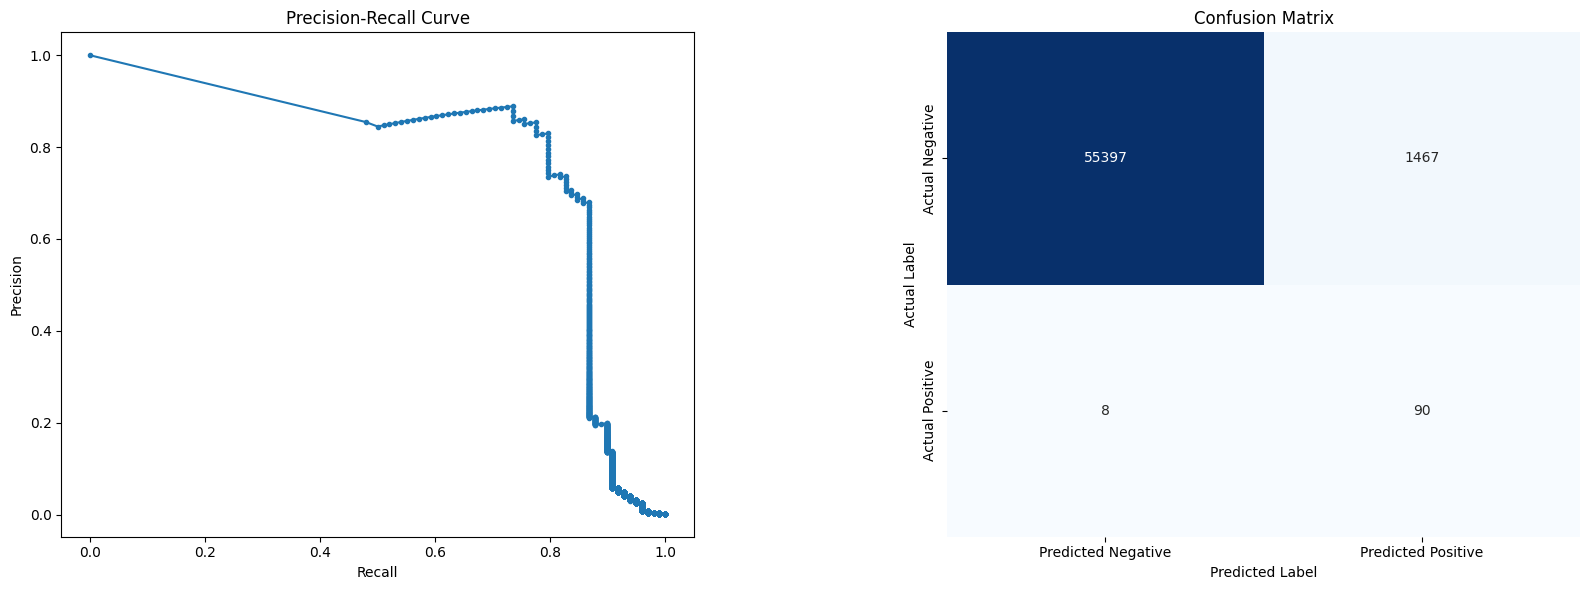

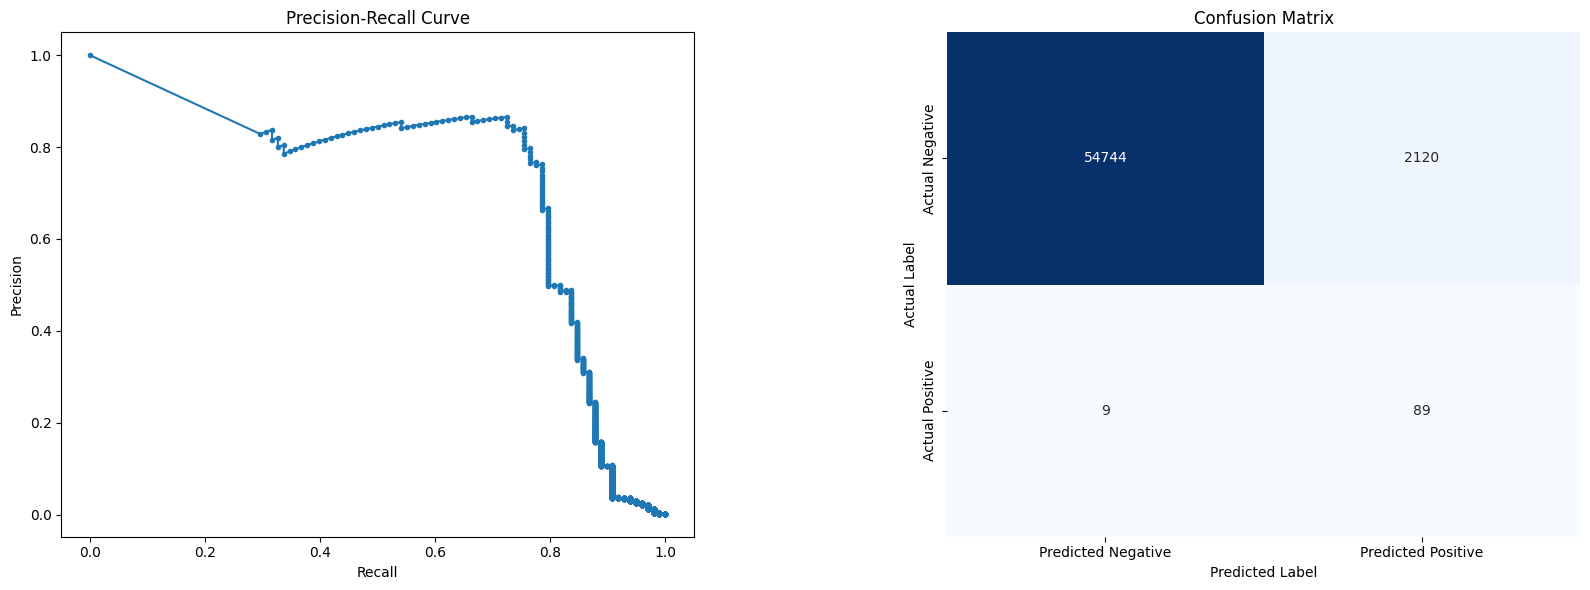

In [23]:
# visualize performance for the over sampled logistic regression
visualize_performance(
    model_output = log_over_output,
    X_test=X_test, 
    y_test=y_test
)

# visualize perfromance for the under sampled logistic regression
visualize_performance(
    model_output = log_under_output,
    X_test=X_test, 
    y_test=y_test, 
)

## random forest

### train and test model

In [24]:
# randome forest with over sampled data
model_name = "random-forest-over"

rf_over_output = train_test_model(
    model_name = model_name,
    X_train = X_train_over,
    y_train = y_train_over,
    X_test = X_test,
    model_function = RandomForestClassifier,
    model_parameters={}
)

# create an empty row in the data from model results with the model name is it's index
model_performance_results.loc[model_name, 'execution_time'] = rf_over_output["execution_time"] 

# print exeuction time
print("oversampling exeuction time:  " + str(rf_over_output["execution_time"]))

oversampling exeuction time:  369.8809089999995


In [25]:
# randome forest with under sampled data
model_name = "random-forest-under"

rf_under_output = train_test_model(
    model_name = model_name,
    X_train = X_train_under,
    y_train = y_train_under,
    X_test = X_test,
    model_function = RandomForestClassifier,
    model_parameters={}
)

# create an empty row in the data from model results with the model name is it's index
model_performance_results.loc[model_name, 'execution_time'] = rf_under_output["execution_time"] 

# print exeuction time
print("oversampling exeuction time:  " + str(rf_under_output["execution_time"]))

oversampling exeuction time:  0.7124414999998407


### display results

In [26]:
# calculate and store model metrics for the over sampled random forest
model_performance_results = pd.concat([
    model_performance_results,
    calculate_metrics(
        model_output = rf_over_output
        ,y_test = y_test
    )
])

# calculate and store model metrics for the under sampled random forest
model_performance_results = pd.concat([
    model_performance_results,
    calculate_metrics(
        model_output = rf_under_output
        ,y_test = y_test
    )
])

display(model_performance_results)

,pr_auc,recall,execution_time,roc_auc,R_squared,f1,precision,model_name
0,NaN,NaN,0.712441,NaN,NaN,NaN,NaN,random-forest-under
logistic-regression-over,NaN,NaN,8.481129,NaN,NaN,NaN,NaN,NaN
logistic-regression-under,NaN,NaN,8.481129,NaN,NaN,NaN,NaN,NaN
logistic-regression-over,0.778539,0.918367,8.481129,0.946284,0.974106,0.108761,0.057803,NaN
logistic-regression-over,0.778539,0.918367,8.481129,0.946284,0.974106,0.108761,0.057803,NaN
logistic-regression-under,0.725327,0.908163,0.041935,0.935441,0.962624,0.077156,0.04029,NaN
logistic-regression-over,0.778539,0.918367,8.481129,0.946284,0.974106,0.108761,0.057803,NaN
logistic-regression-under,0.725327,0.908163,0.041935,0.935441,0.962624,0.077156,0.04029,NaN
random-forest-over,NaN,NaN,369.880909,NaN,NaN,NaN,NaN,NaN
random-forest-under,NaN,NaN,0.712441,NaN,NaN,NaN,NaN,NaN


### visualize results

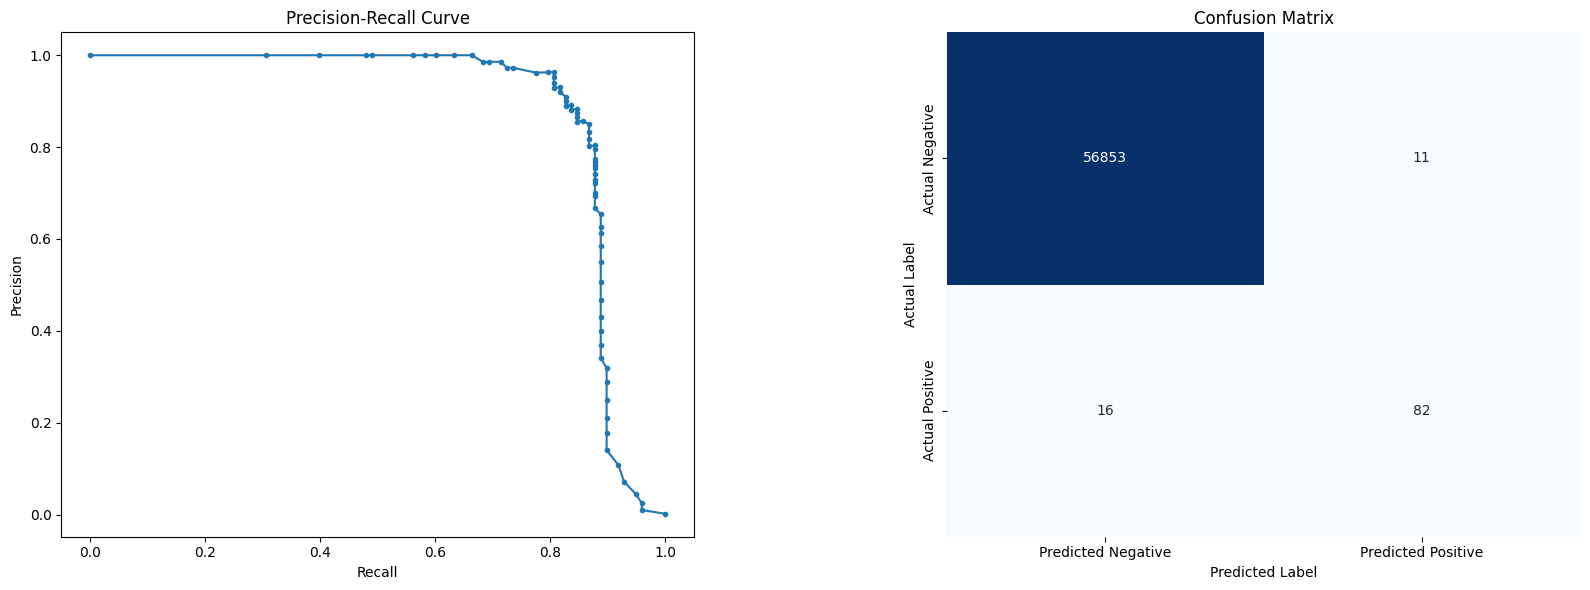

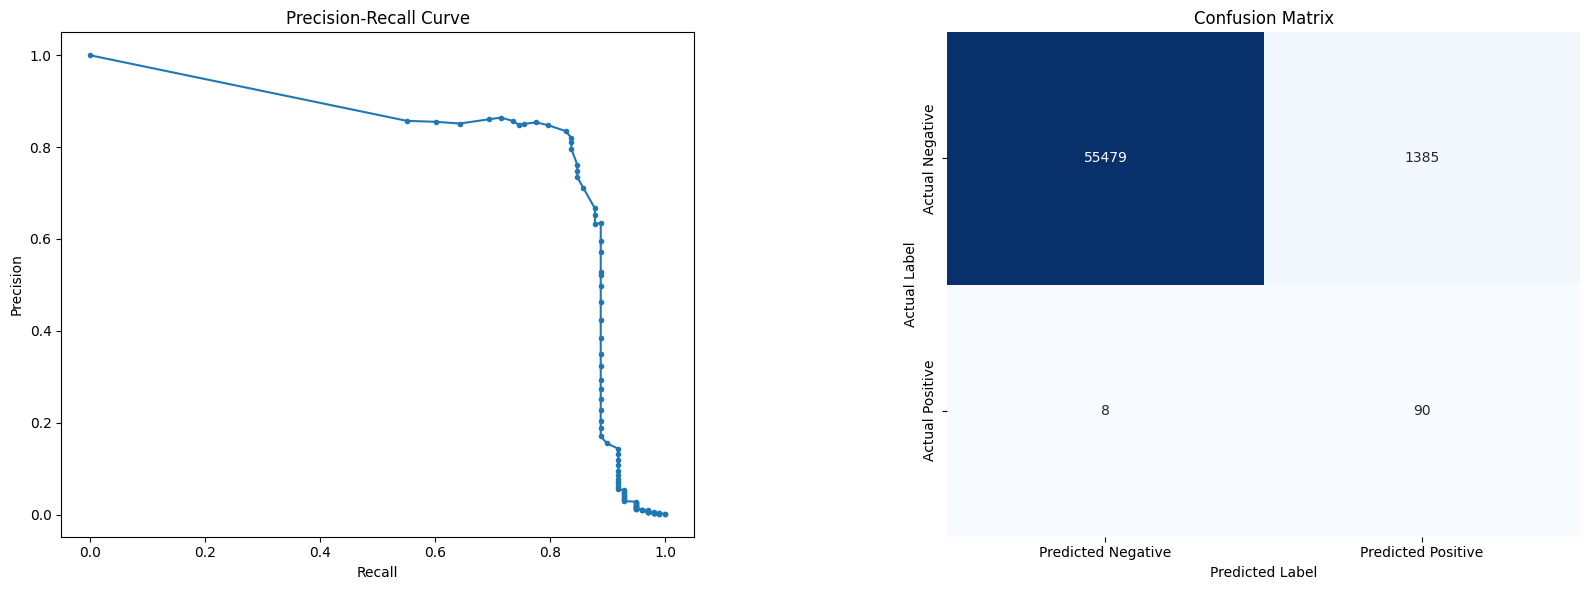

In [27]:
# visualize performance for the over sampled randome forest
visualize_performance(
    model_output = rf_over_output,
    X_test=X_test, 
    y_test=y_test
)

# visualize perfromance for the under sampled random forest
visualize_performance(
    model_output = rf_under_output,
    X_test=X_test, 
    y_test=y_test, 
)

## xgboost

### train and test model

In [33]:
# xgboost with over sampled data
model_name = "xgb-over"

xbg_over_output = train_test_model(
    model_name = model_name,
    X_train = X_train_over,
    y_train = y_train_over,
    X_test = X_test,
    model_function = xgb.XGBClassifier,
    model_parameters={'eval_metric':'mlogloss'}
)

# create an empty row in the data from model results with the model name is it's index
model_performance_results.loc[model_name, 'execution_time'] = xbg_over_output["execution_time"] 

# print exeuction time
print("model exeuction time:  " + str(xbg_over_output["execution_time"]))

model exeuction time:  2.2792155999923125


In [34]:
# xgboost with over sampled data
model_name = "xgb-under"

xbg_under_output = train_test_model(
    model_name = model_name,
    X_train = X_train_under,
    y_train = y_train_under,
    X_test = X_test,
    model_function = xgb.XGBClassifier,
    model_parameters={'eval_metric':'mlogloss'}
)

# create an empty row in the data from model results with the model name is it's index
model_performance_results.loc[model_name, 'execution_time'] = xbg_under_output["execution_time"] 

# print exeuction time
print("model exeuction time:  " + str(xbg_under_output["execution_time"]))

model exeuction time:  0.09560509999573696


### store model results

In [43]:
# calculate and store model metrics for the over sampled random forest
model_performance_results = pd.concat([
    model_performance_results,
    calculate_metrics(
        model_output = xbg_over_output
        ,y_test = y_test
    )
])

# calculate and store model metrics for the under sampled random forest
model_performance_results = pd.concat([
    model_performance_results,
    calculate_metrics(
        model_output = xbg_under_output
        ,y_test = y_test
    )
])

display(model_performance_results)

,pr_auc,recall,execution_time,roc_auc,R_squared,f1,precision,model_name
0,NaN,NaN,0.095605,NaN,NaN,NaN,NaN,xgb-under
logistic-regression-over,NaN,NaN,8.481129,NaN,NaN,NaN,NaN,NaN
logistic-regression-under,NaN,NaN,8.481129,NaN,NaN,NaN,NaN,NaN
logistic-regression-over,0.778539,0.918367,8.481129,0.946284,0.974106,0.108761,0.057803,NaN
logistic-regression-over,0.778539,0.918367,8.481129,0.946284,0.974106,0.108761,0.057803,NaN
logistic-regression-under,0.725327,0.908163,0.041935,0.935441,0.962624,0.077156,0.04029,NaN
logistic-regression-over,0.778539,0.918367,8.481129,0.946284,0.974106,0.108761,0.057803,NaN
logistic-regression-under,0.725327,0.908163,0.041935,0.935441,0.962624,0.077156,0.04029,NaN
random-forest-over,NaN,NaN,369.880909,NaN,NaN,NaN,NaN,NaN
random-forest-under,NaN,NaN,0.712441,NaN,NaN,NaN,NaN,NaN


### visualize results

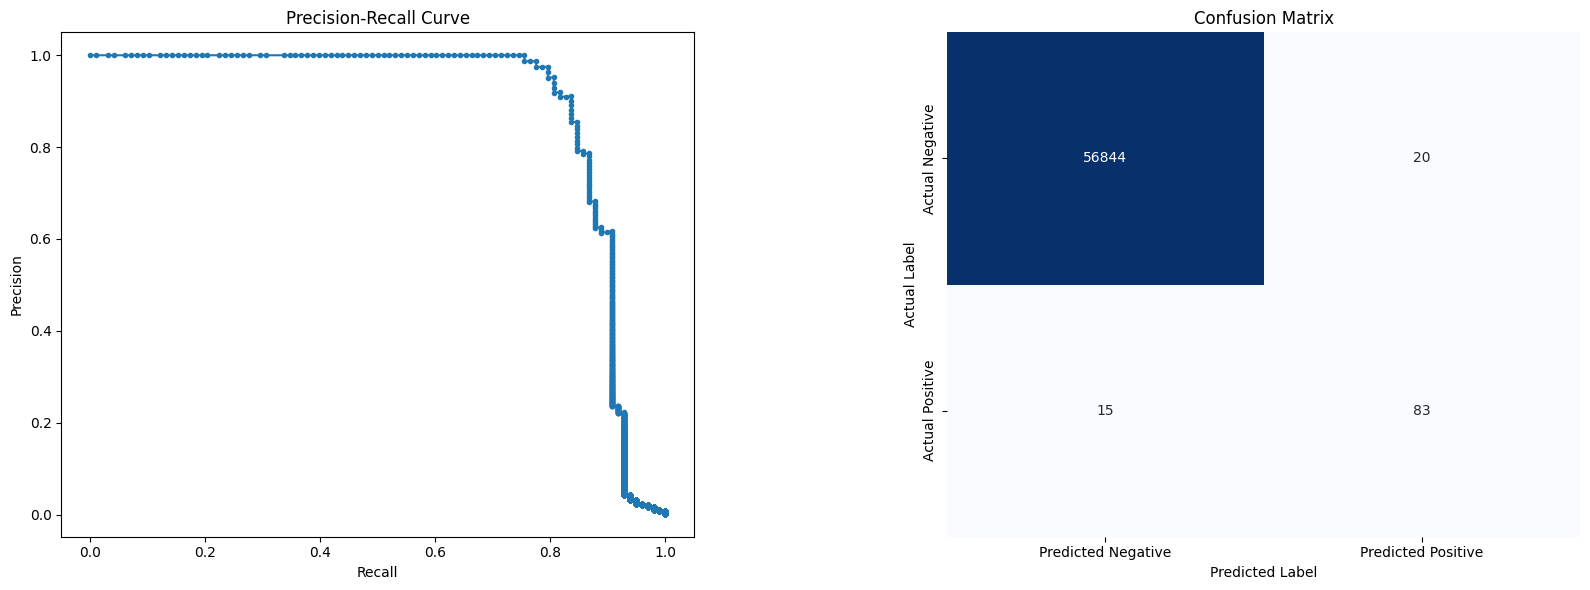

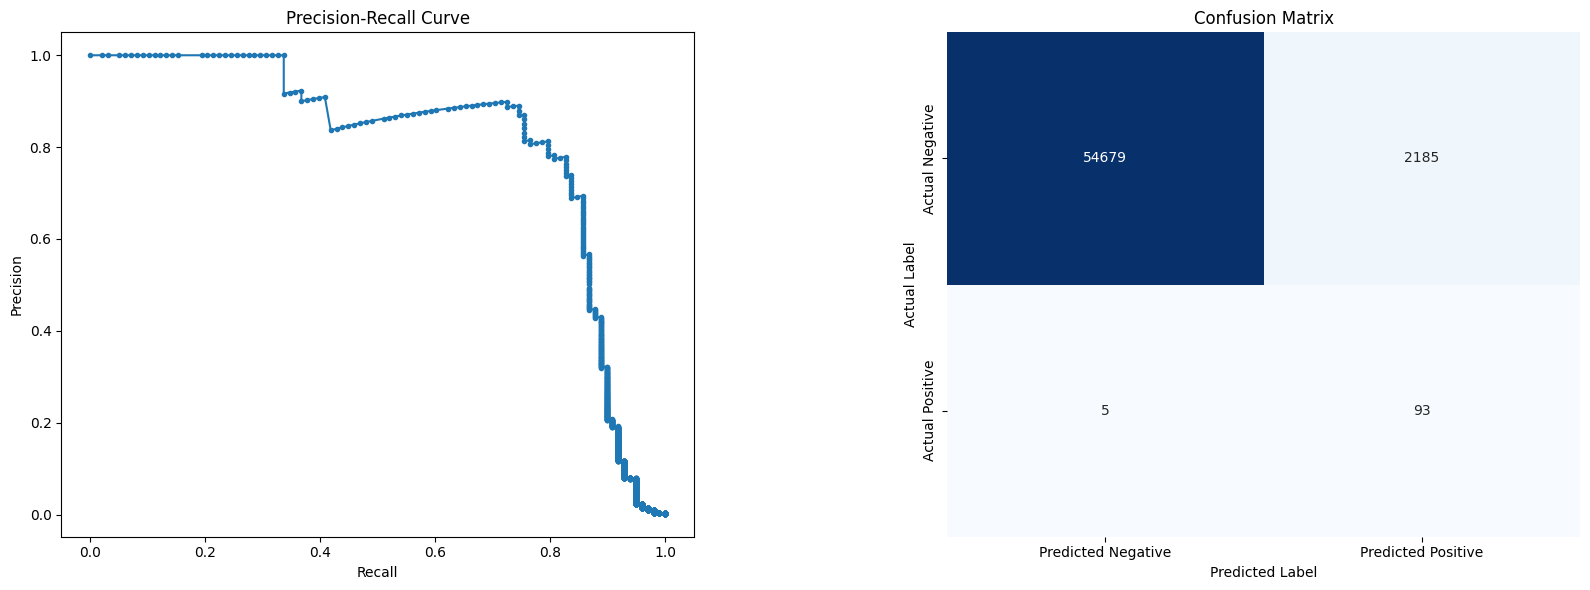

In [44]:
# visualize performance for the over sampled randome forest
visualize_performance(
    model_output = xbg_over_output,
    X_test=X_test, 
    y_test=y_test
)

# visualize perfromance for the under sampled random forest
visualize_performance(
    model_output = xbg_under_output,
    X_test=X_test, 
    y_test=y_test, 
)

## xgboost with scaled weights

There is one additional option I want to modify here within the xgboost model. The xgboost model specifically offers an argument to scale easily scale the positve weight of the values of the target class. 

### train and test model

In [54]:
# Calculate scale_pos_weight
neg_count = sum(y_train_over == 0)
pos_count = sum(y_train_over == 1)
scale_pos_weight = neg_count / pos_count

# train and test with over sampled data
model_name = "xgb-weighted-over"

xbg_weighted_over_output = train_test_model(
    model_name = model_name,
    X_train = X_train_over,
    y_train = y_train_over,
    X_test = X_test,
    model_function = xgb.XGBClassifier,
    model_parameters={'eval_metric':'mlogloss', 'scale_pos_weight': scale_pos_weight}
)

# create an empty row in the data from model results with the model name is it's index
model_performance_results.loc[model_name, 'execution_time'] = xbg_weighted_over_output["execution_time"] 

# print exeuction time
print("model exeuction time:  " + str(xbg_weighted_over_output["execution_time"]))

model exeuction time:  2.1312709000048926


In [55]:
# Calculate scale_pos_weight
neg_count = sum(y_train_under == 0)
pos_count = sum(y_train_under == 1)
scale_pos_weight = neg_count / pos_count

# train and test with over sampled data
model_name = "xgb-weighted-under"

xgb_weighted_under_output = train_test_model(
    model_name = model_name,
    X_train = X_train_under,
    y_train = y_train_under,
    X_test = X_test,
    model_function = xgb.XGBClassifier,
    model_parameters={'eval_metric':'mlogloss', 'scale_pos_weight': scale_pos_weight}
)

# create an empty row in the data from model results with the model name is it's index
model_performance_results.loc[model_name, 'execution_time'] = xgb_weighted_under_output["execution_time"] 

# print exeuction time
print("model exeuction time:  " + str(xgb_weighted_under_output["execution_time"]))

model exeuction time:  0.10520499999984168


### dispaly model results

In [56]:
# calculate and store model metrics for the over sampled random forest
model_performance_results = pd.concat([
    model_performance_results,
    calculate_metrics(
        model_output = xbg_weighted_over_output
        ,y_test = y_test
    )
])

# calculate and store model metrics for the under sampled random forest
model_performance_results = pd.concat([
    model_performance_results,
    calculate_metrics(
        model_output = xgb_weighted_under_output
        ,y_test = y_test
    )
])

display(model_performance_results)

,pr_auc,recall,execution_time,roc_auc,R_squared,f1,precision,model_name
0,NaN,NaN,0.105205,NaN,NaN,NaN,NaN,xgb-weighted-under
logistic-regression-over,NaN,NaN,8.481129,NaN,NaN,NaN,NaN,NaN
logistic-regression-under,NaN,NaN,8.481129,NaN,NaN,NaN,NaN,NaN
logistic-regression-over,0.778539,0.918367,8.481129,0.946284,0.974106,0.108761,0.057803,NaN
logistic-regression-over,0.778539,0.918367,8.481129,0.946284,0.974106,0.108761,0.057803,NaN
logistic-regression-under,0.725327,0.908163,0.041935,0.935441,0.962624,0.077156,0.04029,NaN
logistic-regression-over,0.778539,0.918367,8.481129,0.946284,0.974106,0.108761,0.057803,NaN
logistic-regression-under,0.725327,0.908163,0.041935,0.935441,0.962624,0.077156,0.04029,NaN
random-forest-over,NaN,NaN,369.880909,NaN,NaN,NaN,NaN,NaN
random-forest-under,NaN,NaN,0.712441,NaN,NaN,NaN,NaN,NaN


### visualize models

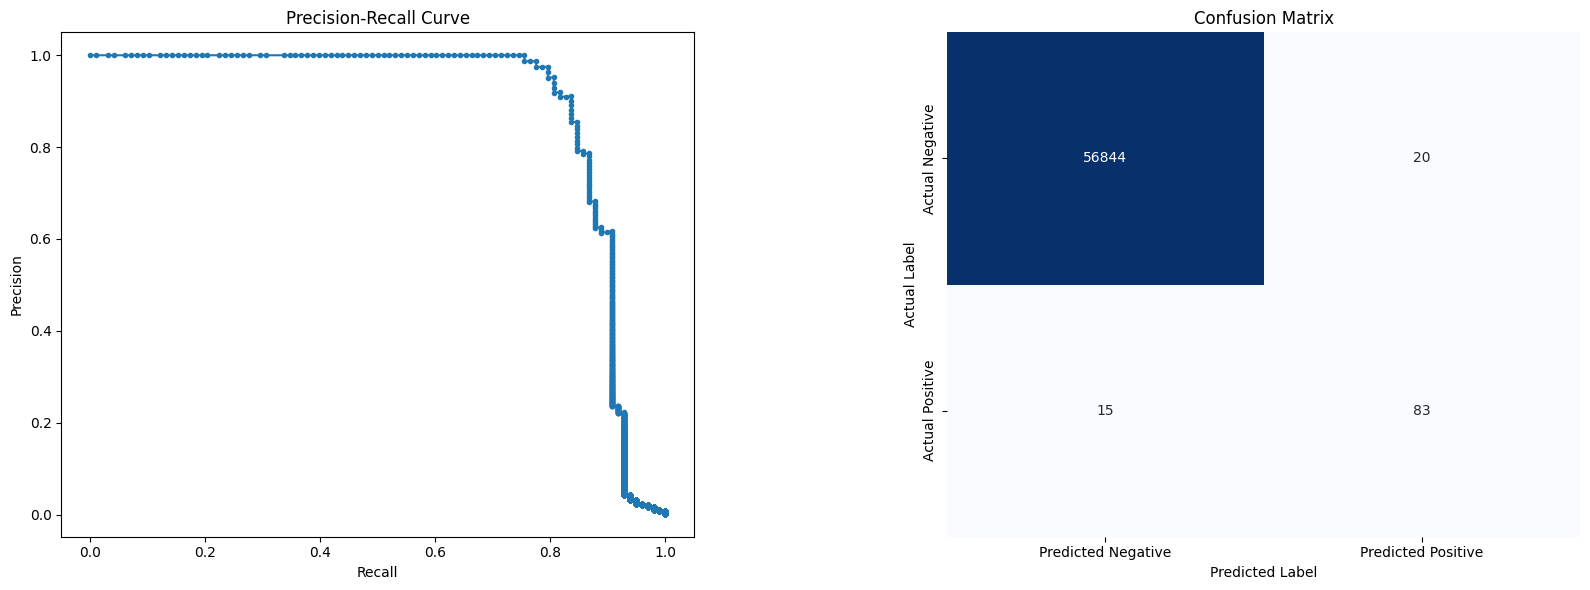

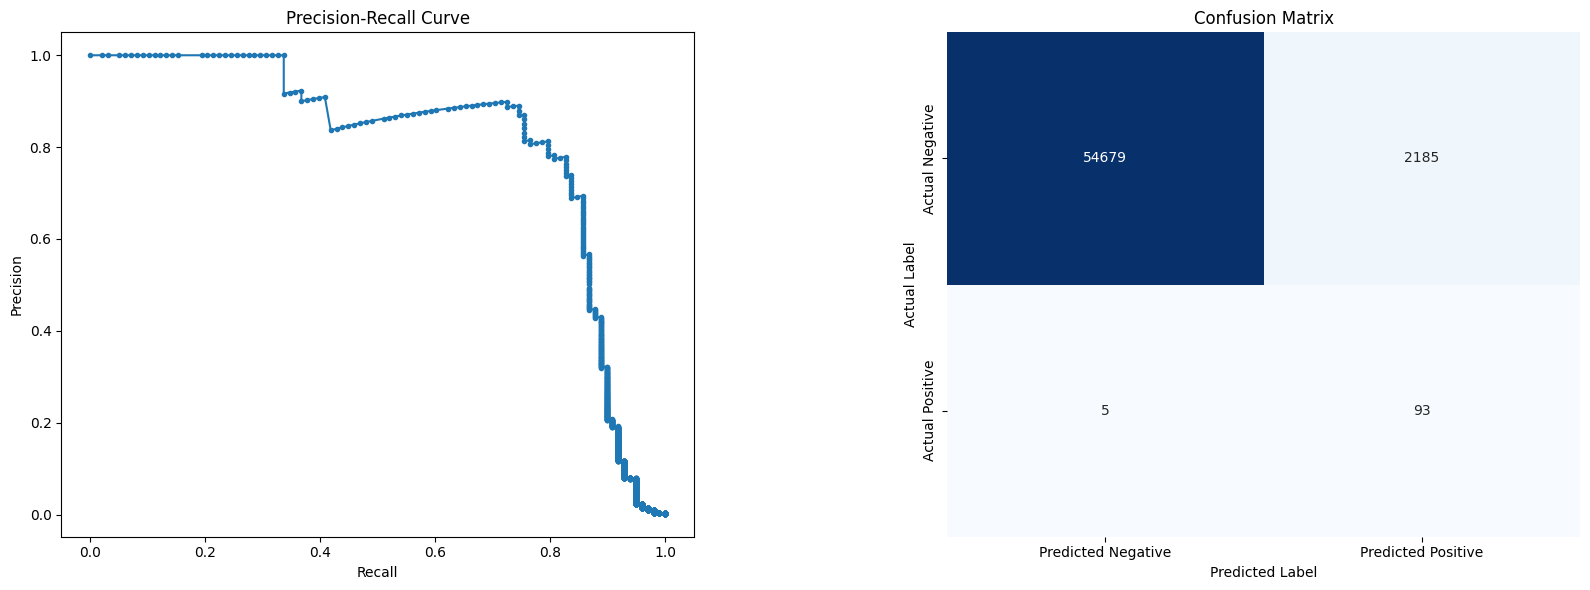

In [57]:
# visualize performance for the over sampled randome forest
visualize_performance(
    model_output = xbg_weighted_over_output,
    X_test=X_test, 
    y_test=y_test
)

# visualize perfromance for the under sampled random forest
visualize_performance(
    model_output = xgb_weighted_under_output,
    X_test=X_test, 
    y_test=y_test, 
)

## best candidate model

Let's review the final scores.

In [ ]:
display(model_performance_results)

## next steps

In this section I am going to address what next steps I would take, if this were a project I was conducted at my own place of work.

### data pre-processing

The first thing I would do if I was with an organziation that controlled the raw data, would be to try different steps in the pre-processing the raw data. Steps I would take when working with the raw data would include:

- personally reviewing the quality of the dat
- examining different options for feature generation on the raw data set
- incorporating additional data, potentially including publically avaialable 3rd party data sets
- trying different dimensionality reduction techniques, specifically UMAP, which I have found to be useful for transactional data in the past

### other models I would like to test

There were additional models I would like to test that are not currently in this project. Including:

- supervised classification methods
    - support vector machines
    - neural networks
        - specfically I would like to try a multi-layered perceptron, which I think would do well with an imbalanced data set
- anaomly detction models

### other methods to handle the imbalance in the data set